In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
from datetime import datetime
import requests
import os

In [2]:
def scrape_stock_list(url="https://www.infomoney.com.br/cotacoes/empresas-b3/"):
    """
    Retrieves stock information from the given URL.

    Parameters:
        url (str, optional): The URL to fetch stock information from. Defaults to
                            "https://www.infomoney.com.br/cotacoes/empresas-b3/".

    Returns:
        dict: A dictionary containing stock information with keys 'stock', 'value','type', and 'link'.

    The function fetches stock information from the specified webpage, including
    stock names, values, types, and links. It returns the data in a dictionary format.

    Example:
        stock_data = get_stock_list()
        print(stock_data)
    """
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    stocks = []
    values = []
    links = []
    types = []

    tables = soup.find_all('table')

    # Iterate through each table
    for table in tables:
        # Find all rows (tr) in the table
        rows = table.find_all('tr')

        # Iterate through each row
        for row in rows:
            # Find the <td class='higher'> containing the name of the stock
            stock_name_td = row.find('td', class_='higher')
            if stock_name_td:
                stock_name = stock_name_td.text.strip()

                # Find all <td class='strong'> containing <a> tags with links and values
                strong_tds = row.find_all('td', class_='strong')
                for strong_td in strong_tds:
                    link_a = strong_td.find('a')
                    if link_a:
                        link = link_a['href']
                        value = link_a.text.strip()

                        # Extract the 'type' from the link
                        type_start = link.find('/b3/') + 4
                        type_end = link.find('/', type_start)
                        asset_type = link[type_start:type_end]

                        # Append data to lists
                        stocks.append(stock_name)
                        values.append(value)
                        links.append(link)
                        types.append(asset_type)

    # Create a DataFrame
    return {'EMPRESA': stocks, 'ATIVO': values, 'TIPO': types, 'LINK': links}

In [3]:
df_stocks = pd.DataFrame(scrape_stock_list())

In [4]:
df_stocks.to_csv('output/stock_list.csv', sep=';', index=False)

In [5]:
df_stocks = df_stocks[~df_stocks['ATIVO'].str.endswith('F')].copy()

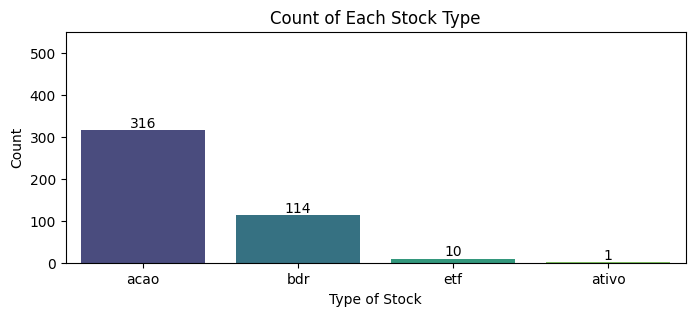

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Criar um gráfico de barras usando seaborn
fig = plt.figure(figsize=(8, 3))
ax = sns.countplot(x='TIPO', data=df_stocks[df_stocks['TIPO']!='fii'], palette='viridis')
plt.xlabel('Type of Stock')
plt.ylabel('Count')
plt.title('Count of Each Stock Type')
plt.ylim(top=550)
# Adicionar a quantidade acima de cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

In [7]:
def click_on_element(driver, method, path, wait_time=15):
    try:
        WebDriverWait(driver, wait_time).until(EC.element_to_be_clickable((method, path))).click()
        return True
    except:
        return False

In [8]:
def get_stock_data(url, tipo, ativo):
    chrome_options = Options()
    chrome_options.add_argument('--headless')  # Run in headless mode
    chrome_options.add_argument('window-size=1920x1080')
    driver = webdriver.Chrome(options=chrome_options)
    # driver.maximize_window()
    driver.get(url)
    _ativo = []
    _tipo = []
    data = []
    abertura = []
    fechamento = []
    variacao = []
    minimo = []
    maximo = []
    volume = []
    # driver.maximize_window()

    #esperar entre 2 e 10 segundos para a pagina carregar
    time.sleep(random.uniform(2, 6))

    # print('Switching to iFrame')
    driver.switch_to.frame(driver.find_element(By.TAG_NAME, "iframe"))

    click_on_element(driver=driver, method=By.XPATH, path='//*[@id="fechar"]')
    # print('Click on close button')

    # print('Switching to the main frame')
    driver.switch_to.default_content()

    driver.implicitly_wait(3)

    date_min_state = click_on_element(driver=driver, method=By.XPATH, path='//*[@id="dateMin"]')
    if date_min_state:
        datemin = driver.find_element(by=By.XPATH, value='//*[@id="dateMin"]')
        datemin.send_keys('01/01/2021')
    else:
        driver.quit()
        return {
                'ATIVO': [],
                'TIPO': [],
                'DATA': [], 
                'ABERTURA': [], 
                'FECHAMENTO': [], 
                'VARIACAO': [],
                'MINIMO': [], 
                'MAXIMO': [], 
                'VOLUME': [], 
            }

    today = datetime.now().strftime("%d/%m/%Y").strip()
    date_max_state = click_on_element(driver=driver, method=By.XPATH, path='//*[@id="dateMax"]')
    if date_max_state:
        datemax = driver.find_element(by=By.XPATH, value='//*[@id="dateMax"]')
        datemax.send_keys(today)
    else:
        driver.quit()
        return {
                'ATIVO': [],
                'TIPO': [],
                'DATA': [], 
                'ABERTURA': [], 
                'FECHAMENTO': [], 
                'VARIACAO': [],
                'MINIMO': [], 
                'MAXIMO': [], 
                'VOLUME': [], 
            }
    
    see_history_state = click_on_element(driver=driver, method=By.XPATH, path='//*[@id="see_all_quotes_history"]')
    if see_history_state:
        # print('Click on see data')
        pass
    else:
        driver.quit()
        return {
                'ATIVO': [],
                'TIPO': [],
                'DATA': [], 
                'ABERTURA': [], 
                'FECHAMENTO': [], 
                'VARIACAO': [],
                'MINIMO': [], 
                'MAXIMO': [], 
                'VOLUME': [], 
            }
    # hold for three seconds fo the page to load
    # time.sleep(2)
    try:
        WebDriverWait(driver, 30).until(EC.invisibility_of_element_located((By.XPATH,  '//*[@id="img_load_more_quotes_history"]')))
    except:
        # print('Loading not completed')
        driver.quit()
        return {
                'ATIVO': [],
                'TIPO': [],
                'DATA': [], 
                'ABERTURA': [], 
                'FECHAMENTO': [], 
                'VARIACAO': [],
                'MINIMO': [], 
                'MAXIMO': [], 
                'VOLUME': [], 
            }

    time.sleep(5)
    #obter o HTML da pagina
    html = driver.page_source

    #Fechar driver do chrome
    driver.quit()

    #Usar o BS4 para analisar o meu html da url
    soup = BeautifulSoup(html, 'html.parser')

    # Encontrar todas as linhas <tr>
    rows = soup.find('table').find_all('tr')

    # Iterar sobre as linhas e extrair os valores
    for row in rows[1:]:
        _ativo.append(ativo)
        _tipo.append(tipo)
        for index, row_value in enumerate(row):
            # row_value.text.
            if index == 0:
                data.append(row_value.text)
            elif index == 1:
                abertura.append(row_value.text)
            elif index == 2:
                variacao.append(row_value.text)
            elif index == 3:
                fechamento.append(row_value.text)
            elif index == 4:
                minimo.append(row_value.text)
            elif index == 5:
                maximo.append(row_value.text)
            elif index == 6:
                volume.append(row_value.text)

    # Create a DataFrame
    return  {
                'ATIVO': _ativo,
                'TIPO': _tipo,
                'DATA': data, 
                'ABERTURA': abertura, 
                'FECHAMENTO': fechamento, 
                'VARIACAO': variacao,
                'MINIMO': minimo, 
                'MAXIMO': maximo,
                'VOLUME': volume, 
            }

In [9]:
df_stocks.head()

,EMPRESA,ATIVO,TIPO,LINK
0,Grupo Casas Bahia,BHIA3,acao,https://www.infomoney.com.br/cotacoes/b3/acao/...
1,Riza Arctium Real Estate FII Closed Fund,RZAT11,fii,https://www.infomoney.com.br/cotacoes/b3/fii/r...
2,Fiagro Greenwich Fundo de Investimento nas Cad...,GRWA11,fii,https://www.infomoney.com.br/cotacoes/b3/fii/f...
3,Sparta Fiagro Fundo de Investimento Cadeias Pr...,CRAA11,fii,https://www.infomoney.com.br/cotacoes/b3/fii/s...
4,ZAMP S.A.,ZAMP3,acao,https://www.infomoney.com.br/cotacoes/b3/acao/...


In [10]:
header_df = ['ATIVO', 'TIPO', 'DATA', 'ABERTURA', 'FECHAMENTO', 'VARIACAO', 'MINIMO', 'MAXIMO', 'VOLUME']
df_resultados = pd.DataFrame(columns=header_df)
df_fail = pd.DataFrame(columns=['ATIVO', 'TIPO', 'LINK'])

In [11]:
df_filtered = df_stocks[df_stocks['ATIVO']=='BHIA3']
num_of_assets = df_filtered.shape[0]
num_loaded = 0
num_failed = 0
couting = 0

for index, row in df_filtered.iterrows(): 
    link = row['LINK']
    tipo = row['TIPO']
    ativo = row['ATIVO']
    print(f'########  Loading: {ativo} ########')
    for i in range(2):
        # Chamar o método de busca
        resultado = get_stock_data(f"{link}historico/", tipo, ativo)
        if len(resultado['ATIVO']) == 0:
            if i == 1:
                print(f'########  Add {ativo} to df_fail')
                df_fail = pd.concat([df_fail, pd.DataFrame.from_dict({'ATIVO':[ativo], 'TIPO':[tipo], 'LINK':[link]})], ignore_index=True)
                num_failed = num_failed + 1  
        else:
            df_resultados = pd.concat([df_resultados, pd.DataFrame.from_dict(resultado)], ignore_index=True)
            print(f'########  {ativo} loaded!')
            num_loaded = num_loaded + 1          
            break
    couting = couting + 1
    print(f'########  Done: {couting}/{num_of_assets} ########')
    print(f'########  Loaded: {num_loaded}/{num_of_assets} ########')
    print(f'########  Failed: {num_failed}/{num_of_assets} ########\n')

########  Loading: BHIA3 ########
########  BHIA3 loaded!
########  Done: 1/1 ########
########  Loaded: 1/1 ########
########  Failed: 0/1 ########



In [12]:
df_resultados

,ATIVO,TIPO,DATA,ABERTURA,FECHAMENTO,VARIACAO,MINIMO,MAXIMO,VOLUME
0,BHIA3,acao,24/11/2023,"0,57","-8,62","0,53","0,53","0,58","43,39M"
1,BHIA3,acao,23/11/2023,"0,57","1,75","0,58","0,56","0,59","28,97M"
2,BHIA3,acao,22/11/2023,"0,59","-1,72","0,57","0,57","0,62","54,68M"
3,BHIA3,acao,21/11/2023,"0,60","-1,69","0,58","0,56","0,61","41,84M"
4,BHIA3,acao,20/11/2023,"0,58","3,51","0,59","0,57","0,60","34,35M"
...,...,...,...,...,...,...,...,...,...
495,BHIA3,acao,01/12/2021,"5,81","-8,29","5,20","5,20","5,85","206,73M"
496,BHIA3,acao,30/11/2021,"5,79","-3,08","5,67","5,55","5,88","247,16M"
497,BHIA3,acao,29/11/2021,"5,79","2,99","5,85","5,65","5,93","206,97M"
498,BHIA3,acao,26/11/2021,"5,72","-4,54","5,68","5,60","5,83","189,53M"


In [39]:
# Specify the desired directory
directory = 'output'

# Check if the directory exists, and create it if not
if not os.path.exists(directory):
    os.makedirs(directory)

In [40]:
# df_resultados.to_csv(f'{directory}/25112023stoks.csv', index=False, sep=';')

In [41]:
# df_fail.to_csv(f'{directory}/25112023stoks_failed.csv', index=False, sep=';')

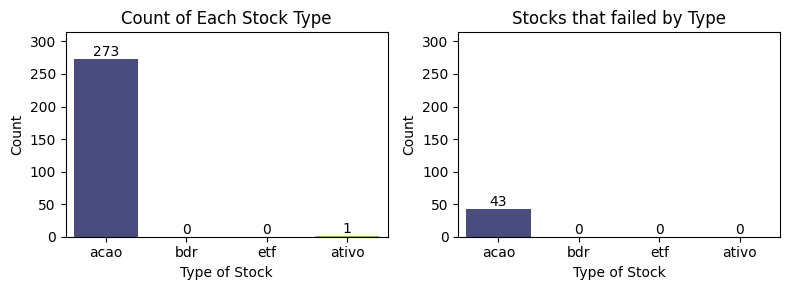

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Criar um gráfico de barras usando seaborn
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

df_unique = df_resultados.drop_duplicates(subset=['ATIVO', 'TIPO'])
ax = sns.countplot(x='TIPO', data=df_unique, order=['acao', 'bdr', 'etf', 'ativo'], palette='viridis', ax=axes[0])
axes[0].set_xlabel('Type of Stock')
axes[0].set_ylabel('Count')
axes[0].set_title('Count of Each Stock Type')
axes[0].tick_params(axis='y', labelleft=True) 
# plt.ylim(top=550)
# Adicionar a quantidade acima de cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

ax_fail = sns.countplot(x='TIPO', data=df_fail, order=['acao', 'bdr', 'etf', 'ativo'], palette='viridis', ax=axes[1])
axes[1].set_xlabel('Type of Stock')
axes[1].set_ylabel('Count')
axes[1].set_title('Stocks that failed by Type')
axes[1].tick_params(axis='y', labelleft=True) 

# Calcular o limite superior para a y-axis separadamente para cada gráfico
ylim_top_unique = df_unique['TIPO'].value_counts().max() * 1.15  # Aumentar 15%
ylim_top_fail = df_fail['ATIVO'].value_counts().max() * 1.15  # Aumentar 15%
limit = 0
if ylim_top_unique > ylim_top_fail:
    limit = ylim_top_unique
else:
    limit = ylim_top_fail
# Ajustar o limite superior da y-axis em ambos os gráficos
axes[0].set_ylim(top=limit)
axes[1].set_ylim(top=limit)

plt.tight_layout()
# plt.ylim(top=550)
# Adicionar a quantidade acima de cada barra
for p in ax_fail.patches:
    ax_fail.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

<h3> SPARK

In [13]:
from pyspark import SparkContext

In [14]:
# Definindo a função de mapeamento paa converter cada valor de fechamento
def mapper(value):
    return(value, 1)

# Definindo a função de redução para domar os valores de fechamento
def reducer(a,b):
    return a + b

In [15]:
colunas_numericas = ['ABERTURA', 'FECHAMENTO', 'VARIACAO', 'MINIMO', 'MAXIMO']
df_resultados[colunas_numericas] = df_resultados[colunas_numericas].replace(',', '.', regex=True).apply(pd.to_numeric, errors='coerce')

In [16]:
df_final = df_resultados.copy()

In [17]:
# Inicnaod o Spark Context
os.environ['PYSPARK_PYTHON'] = r'C:/Python310/python.exe'
import findspark
findspark.init()
sc = SparkContext.getOrCreate()

# Criando um RDD a partir da coluna Fechamento
print("SERIALIZANDO")
fechamento_rdd = sc.parallelize(df_final['FECHAMENTO'].to_list())

print("MAP REDUCE")
# Realizando a operação do mapreduce
result = fechamento_rdd.map(mapper).reduceByKey(reducer).collect()

# Criando um dicionario a partir do resultado
result_dict = dict(result)

print("MAP")
# Adicionado o resultado ao "df_final" com uma nova coluna
df_final['QTDE_VALORES_IGUAIS'] = df_final['FECHAMENTO'].map(result_dict)

SERIALIZANDO
MAP REDUCE
MAP


In [18]:
df_final.head()

,ATIVO,TIPO,DATA,ABERTURA,FECHAMENTO,VARIACAO,MINIMO,MAXIMO,VOLUME,QTDE_VALORES_IGUAIS
0,BHIA3,acao,24/11/2023,0.57,-8.62,0.53,0.53,0.58,"43,39M",1
1,BHIA3,acao,23/11/2023,0.57,1.75,0.58,0.56,0.59,"28,97M",1
2,BHIA3,acao,22/11/2023,0.59,-1.72,0.57,0.57,0.62,"54,68M",3
3,BHIA3,acao,21/11/2023,0.60,-1.69,0.58,0.56,0.61,"41,84M",1
4,BHIA3,acao,20/11/2023,0.58,3.51,0.59,0.57,0.60,"34,35M",2


In [19]:
# Calculando a media
print("MÉDIA")
media_fechamento = df_final.groupby('ATIVO')['FECHAMENTO'].mean()
media_fechamento = media_fechamento.round(2)

MÉDIA


In [20]:
media_fechamento = media_fechamento.rename('MÉDIA_POR_ATIVO')

In [21]:
media_fechamento

ATIVO
BHIA3   -0.37
Name: MÉDIA_POR_ATIVO, dtype: float64

In [22]:
# Converter a coluna 'DATA' para o tipo datetime
df_final['DATA'] = pd.to_datetime(df_final['DATA'], format='%d/%m/%Y')

# Criar uma nova coluna 'MÊS' para extrair o mês da data
df_final['MÊS'] = df_final['DATA'].dt.month
df_final['ANO'] = df_final['DATA'].dt.year

In [28]:
media_fechamento_por_mes = df_final.groupby(['ATIVO', 'ANO', 'MÊS'])['FECHAMENTO'].mean()

In [29]:
media_fechamento_por_mes.rename('MÉDIA_FECHAMENTO_POR_DATA')

ATIVO  ANO   MÊS
BHIA3  2021  11    -0.817500
             12    -0.272857
       2022  1     -0.435238
             2     -1.085789
             3      0.493182
             4     -1.727368
             5      0.304545
             6     -2.232857
             7      1.230952
             8      1.472174
             9      0.049048
             10     0.020000
             11    -1.691000
             12     0.602857
       2023  1      0.092273
             2     -1.136111
             3     -0.010435
             4     -0.056667
             5      1.231364
             6     -0.399524
             7      0.058095
             8     -2.226522
             9     -3.388421
             10    -1.487619
             11     1.295625
Name: MÉDIA_FECHAMENTO_POR_DATA, dtype: float64

In [33]:
df_final = df_final.merge(media_fechamento, on='ATIVO')

In [ ]:
# Calculando a media
print("MÉDIA")
media_fechamento = df_final.groupby('ATIVO')['FECHAMENTO'].mean()
media_fechamento = media_fechamento.rename('MÉDIA_POR_ATIVO')

# Converter a coluna 'DATA' para o tipo datetime
df_final['DATA'] = pd.to_datetime(df_final['DATA'], format='%d/%m/%Y')

# Criar uma nova coluna 'MÊS' para extrair o mês da data
df_final['MÊS'] = df_final['DATA'].dt.month
df_final['ANO'] = df_final['DATA'].dt.year

# Calcular a média do fechamento por mês, ano e ativo
media_fechamento_por_mes = df_final.groupby(['ATIVO', 'ANO', 'MÊS'])['FECHAMENTO'].mean().reset_index()
media_fechamento_por_mes = media_fechamento_por_mes.rename('MÉDIA_FECHAMENTO_POR_MÊS')

# Arredondamento de média
print("ROUND 2")
media_fechamento = media_fechamento.round(2)
media_fechamento_por_mes = media_fechamento_por_mes.round(2)

print("TRY TO MERGE")
df_final['DATA'] = df_final['DATA'].dt.strftime('%d/%m/%Y')
# Adicionando a media ao df_final com uma nova colunas
df_final = df_final.merge(media_fechamento, on='ATIVO', suffixes=('', '_MEDIA'))
# Merge dos DataFrames usando múltiplas colunas como critério
df_final = df_final.merge(media_fechamento_por_mes, on=['ATIVO', 'MÊS', 'ANO'], suffixes=('', '_MEDIA_FECHAMENTO'))

print("MERGED")
# Criando um escritor no excel
writer = pd.ExcelWriter('dados_NEW.xlsx', engine='xlsxwriter')

# Gravando o df_final na guia 'Analise_PYSPARK'
df_final.to_excel(writer, sheet_name='Analise_PYSPARK', index=False)
print("ARQUIVO SALVO")
# Salvando
writer.close()

In [35]:
def calculation(df_final: pd.DataFrame):
    # Calculando a media
    print("MÉDIA")
    media_fechamento = df_final.groupby('ATIVO')['FECHAMENTO'].mean()
    media_fechamento = media_fechamento.rename('MÉDIA_POR_ATIVO')

    # Converter a coluna 'DATA' para o tipo datetime
    df_final['DATA'] = pd.to_datetime(df_final['DATA'], format='%d/%m/%Y')

    # Criar uma nova coluna 'MÊS' para extrair o mês da data
    df_final['MÊS'] = df_final['DATA'].dt.month
    df_final['ANO'] = df_final['DATA'].dt.year

    # Calcular a média do fechamento por mês, ano e ativo
    media_fechamento_por_mes = df_final.groupby(['ATIVO', 'ANO', 'MÊS'])['FECHAMENTO'].mean().reset_index()
    media_fechamento_por_mes = media_fechamento_por_mes.rename('MÉDIA_FECHAMENTO_POR_MÊS')

    # Arredondamento de média
    print("ROUND 2")
    media_fechamento = media_fechamento.round(2)
    media_fechamento_por_mes = media_fechamento_por_mes.round(2)

    print("TRY TO MERGE")
    df_final['DATA'] = df_final['DATA'].dt.strftime('%d/%m/%Y')
    # Adicionando a media ao df_final com uma nova colunas
    df_final = df_final.merge(media_fechamento, on='ATIVO', suffixes=('', '_MEDIA'))
    # Merge dos DataFrames usando múltiplas colunas como critério
    df_final = df_final.merge(media_fechamento_por_mes, on=['ATIVO', 'MÊS', 'ANO'], suffixes=('', '_MEDIA_FECHAMENTO'))

    df_final.drop(['ANO', 'MÊS'], axis=1, inplace=True)

    print("MERGED")
    # Criando um escritor no excel
    writer = pd.ExcelWriter('dados_NEW.xlsx', engine='xlsxwriter')

    # Gravando o df_final na guia 'Analise_PYSPARK'
    df_final.to_excel(writer, sheet_name='Analise_PYSPARK', index=False)
    print("ARQUIVO SALVO")
    # Salvando
    writer.close()